 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#A-simple-neural-network-in-Numpy" data-toc-modified-id="A-simple-neural-network-in-Numpy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A simple neural network in Numpy</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Define-backpropagation-in-numpy" data-toc-modified-id="Define-backpropagation-in-numpy-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Define backpropagation in numpy</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Train-the-network" data-toc-modified-id="Train-the-network-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train the network</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Building-a-neural-network-in-Keras" data-toc-modified-id="Building-a-neural-network-in-Keras-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Building a neural network in Keras</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Post-processing:-The-data" data-toc-modified-id="Post-processing:-The-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Post-processing: The data</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Simple-postprocessing" data-toc-modified-id="Simple-postprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simple postprocessing</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Add-station-information-with-embeddings" data-toc-modified-id="Add-station-information-with-embeddings-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Add station information with embeddings</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#What-about-a-neural-network?" data-toc-modified-id="What-about-a-neural-network?-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>What about a neural network?</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Adding-more-variables" data-toc-modified-id="Adding-more-variables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Adding more variables</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Simple-linear-net-with-auxiliary-variables" data-toc-modified-id="Simple-linear-net-with-auxiliary-variables-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Simple linear net with auxiliary variables</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Auxiliary-variables-with-station-embeddings" data-toc-modified-id="Auxiliary-variables-with-station-embeddings-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Auxiliary variables with station embeddings</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Neural-network" data-toc-modified-id="Neural-network-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Neural network</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#A-more-complex-neural-network" data-toc-modified-id="A-more-complex-neural-network-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>A more complex neural network</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Hmmm,-weird..." data-toc-modified-id="Hmmm,-weird...-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Hmmm, weird...</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#A-longer-training-period" data-toc-modified-id="A-longer-training-period-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>A longer training period</a></span></li><li><span><a href="http://localhost:8888/notebooks/presentation_notebook.ipynb#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Neural networks for post-processing NWP forecasts

In [191]:
# Imports 
import numpy as np
import sys
sys.path.append('../')   # This is where all the python files are!
from importlib import reload
import utils; reload(utils)
from utils import *
import keras_models; reload(keras_models)
from keras_models import *
from losses import crps_cost_function
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
import seaborn as sns
sns.set_style('dark')
sns.set_context('poster')
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict
from IPython.display import HTML
import time
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in [crps_cost_function]])
get_custom_objects().update(metrics_dict)

Anaconda environment: py36_keras
Darwin 17.3.0


In [2]:
# Basic setup
DATA_DIR = '/Volumes/STICK/data/ppnn_data/'  # Mac
# DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # LMU

## A simple neural network in Numpy

So what is a neural network anyway. Let's start by looking at a picture.

![Neural network](general_nn.png)

A neural network consists of several layers of interconnected nodes. Each node represents a weighted sum of all the nodes in the previous layers plus a bias.

$$\sum_j w_j x_j + b$$

Additionally, each hidden layer is modified by a non-linear function $g(z)$. One very simple and popular activation function is called ReLU:

$$\mathrm{relu}(z) = \mathrm{max}(0, z)$$

Let's build a simplified network with one input and one output in pure Numpy.

(50, 1)

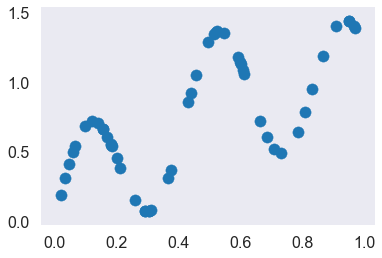

In [3]:
# Create the data
n_samples = 50
x = np.expand_dims(np.random.uniform(0, 1, n_samples), -1)
y = np.sin(2 * x) + 0.5 * np.sin(15 * x)
plt.scatter(x, y);
x.shape

In [58]:
# Initialize the weights and biases for the input --> hidden layer step
n_hidden = 200   # Number of nodes in hidden layer
w1 = np.random.normal(size=(1, n_hidden))   # a matrix
b1 = np.random.normal(size=n_hidden)        # a vector
w1.shape, b1.shape

((1, 200), (200,))

In [59]:
# Do the first step 
hidden = np.dot(x, w1) + b1
hidden.shape

(50, 200)

In [60]:
# Here comes the non-linearity
def relu(z):
    return np.maximum(0, z)

In [61]:
hidden = relu(hidden)

In [62]:
# Now the weights and biases for the hidden --> output step
w2 = np.random.normal(size=(n_hidden, 1))
b2 = np.random.normal(size=1)
w2.shape, b2.shape

((200, 1), (1,))

In [63]:
# Now the second step
preds = np.dot(hidden, w2) + b2
preds.shape

(50, 1)

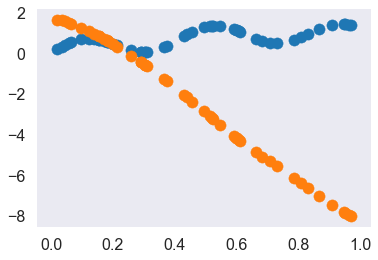

In [64]:
plt.scatter(x, y);
plt.scatter(x, preds);

Now this is of course just some random garbage. The goal of the optimization algorithm is to change the weights and biases to get the output closer to the target. Mathematically, we are minimizing a loss function, for example the mean squared error.

$$L = \frac{1}{N_\mathrm{{samples}}} \sum_{i=1}^{N_\mathrm{{samples}}} (\mathrm{output} - \mathrm{target})^2$$

To minimize this loss we are using stochastic gradient descent. For this we need to compute the gradient of the loss with respect to all weights and biases. Basically, this mean using the chain rule of calculus. The algorithm to do this efficiently is called backpropagation.

In [65]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [66]:
mse(preds, y)

21.431198223748574

### Define backpropagation in numpy

In [67]:
# Some helper function to reset the weights
def init_weights(n_hidden):
    w1 = np.random.normal(size=(1, n_hidden))   # a matrix
    b1 = np.random.normal(size=n_hidden)        # a vector
    w2 = np.random.normal(size=(n_hidden, 1))
    b2 = np.random.normal(size=1)
    return [w1, w2], [b1, b2]

In [68]:
# First define the forward pass.
def forward_pass(x, weights, biases):
    hidden = relu(np.dot(x, weights[0]) + biases[0])
    return np.dot(hidden, weights[1]) + biases[1]

In [69]:
# Define the derivative of the loss function and the activation function
def dmse(predictions, targets):
    return predictions - targets
def drelu(z):
    return 1. * (z > 0)

In [70]:
def backprop_and_update(x, y, weights, biases, lr=1e-5):
    # Compute the predictions
    hidden = relu(np.dot(x, weights[0]) + biases[0])
    preds = np.dot(hidden, weights[1]) + biases[1]
    
    # Compute the loss
    loss = mse(preds, y)
    
    # Compute Ds
    delta2 = dmse(preds, y)
    dw2 = np.dot(hidden.T, delta2)
    db2 = np.sum(delta2, axis=0)
    delta1 = np.dot(delta2, weights[1].T)  * drelu(hidden)
    dw1 = np.dot(x.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update parameters
    weights[0] -= lr * dw1
    biases[0] -= lr * db1
    weights[1] -= lr * dw2
    biases[1] -= lr * db2
    
    return loss

### Train the network

In [92]:
weights, biases = init_weights(n_hidden)

In [93]:
n_steps = 50000
saved_preds = []
pbar = tqdm(total=n_steps)
for i in range(n_steps):
    loss = backprop_and_update(x, y, weights, biases, lr=1e-4)
    pbar.update(1)
    pbar.set_postfix(OrderedDict({'loss': loss}))
    if i % 500 == 0:
        saved_preds.append(forward_pass(x, weights, biases))
pbar.close()

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

In [94]:
saved_preds = np.array(saved_preds)
saved_preds.shape

(100, 50, 1)

In [95]:
fig, ax = plt.subplots()
ax.scatter(x, y)
s = ax.scatter(x[:, 0], saved_preds[0, :, 0])
ax.set_ylim(0, 2)
def animate(i):
    y_i = saved_preds[i, :, 0]
    s.set_offsets(np.array([x[:, 0], y_i]).T)
plt.close();

In [98]:
ani = animation.FuncAnimation(fig, animate, np.arange(saved_preds.shape[0]),
                              interval=100)

In [99]:
HTML(ani.to_html5_video())

### Building a neural network in Keras

In [110]:
network = Sequential([
    Dense(n_hidden, input_dim=1, activation='relu'),
    Dense(1)
])
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


In [111]:
network.compile(SGD(), 'mse')

In [112]:
network.fit(x, y, batch_size=x.shape[0], epochs=10)

Epoch 1/10
50/50 [==============================] - 0s - loss: 0.6287
Epoch 2/10
50/50 [==============================] - 0s - loss: 0.5833
Epoch 3/10
50/50 [==============================] - 0s - loss: 0.5423
Epoch 4/10
50/50 [==============================] - 0s - loss: 0.5052
Epoch 5/10
50/50 [==============================] - 0s - loss: 0.4715
Epoch 6/10
50/50 [==============================] - 0s - loss: 0.4408
Epoch 7/10
50/50 [==============================] - 0s - loss: 0.4128
Epoch 8/10
50/50 [==============================] - 0s - loss: 0.3873
Epoch 9/10
50/50 [==============================] - 0s - loss: 0.3640
Epoch 10/10
50/50 [==============================] - 0s - loss: 0.3427


## Post-processing: The data

In post-processing we want to correct model biases by looking at past forecast/observation pairs. Specifically, if we are looking at probabilistic/ensemble forecasts, we want the forecast to be calibrated. For example, for all cases where the forecasts say that the chance of rain is 40%, it should actually rain in 40% of these cases.

For this study we are looking at 48h ensemble forecasts of temperature at around DWD 500 surface stations in Germany. Our forecasts are ECMWF 50 member ensemble forecasts taken from the TIGGE dataset which contain forecasts from 2008 to now upscaled to 40km grid spacing. The forecast data was bilinearly interpolated to the station locations.

We will use all of 2015 for training the model and all of 2016 to test how well the model performs.

In [117]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates)

train set contains 365 days
test set contains 366 days


The raw ensemble contains 50 ensemble members. We take the mean and standard deviations of these 50 values which is a good approximation since temperature is normally distributed.

In [118]:
train_set.feature_names

['t2m_fc_mean', 't2m_fc_std']

In total we have around 500 stations for every day with some missing observation data. In total that makes around 180k samples.

In [119]:
len(np.unique(train_set.station_ids))

500

In [120]:
train_set.features.shape, train_set.targets.shape

((180849, 2), (180849,))

In [121]:
def plot_fc(data_set, idx, distr='pdf'):
    fc = data_set.features[idx] * data_set.scale_factors
    obs = data_set.targets[idx]
    x = np.linspace(fc[0] - 5 * fc[1], fc[0] + 5 * fc[1], 100)
    if distr == 'pdf':
        y = norm.pdf(x, fc[0], fc[1])
    elif distr == 'cdf':
        y = norm.cdf(x, fc[0], fc[1])
    else:
        raise Exception
    plt.plot(x, y)
    plt.axvline(obs, color='red')
    plt.xlabel('Temperature [C]')
    plt.show()

The goal of post-processing is to produce a sharp but reliable distribution.

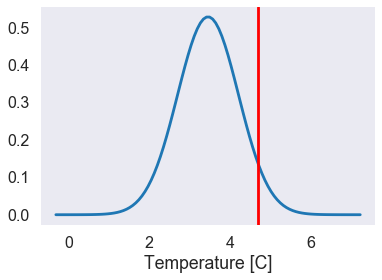

In [122]:
plot_fc(train_set, 1001)

To measure the skill of the forecast, we use the CRPS: 


$$ \mathrm{crps}(F, y) = \int_{-\infty}^{\infty} [F(t) - H(t-y)]^2\mathrm{d}t, $$

where $F(t)$ is the forecast CDF and $H(t-y)$ is the Heaviside function.

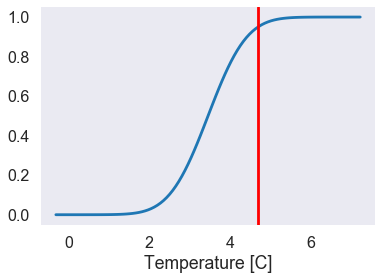

In [123]:
plot_fc(train_set, 1001, 'cdf')

For a normal distribution we can easily compute the CRPS from the mean and standard deviation for the raw ensemble, which is the score we want to improve.

In [124]:
np.mean(crps_normal(
    test_set.features[:, 0] * test_set.scale_factors[0], 
    test_set.features[:, 1] * test_set.scale_factors[1], 
    test_set.targets
))

1.1518655803868305

## Simple postprocessing

The most common post-processing technique for this sort of problem is called Ensemble Model Output Statistic (Gneiting et al. 2005). In this technique, the goal is to find a distribution
$$ \mathcal{N}(a + bX, c + dS^2), $$
where $X$ is the raw ensemble mean and $S$ is the raw ensemble standard deviation, so that 
$$ \min_{a, b, c, d} \frac{1}{N_{\mathrm{sample}}} \sum_{i = 1}^{N_{\mathrm{sample}}} crps(\mathcal{N}(a + bX, c + dS^2), y_i)$$
The minimum over all samples is found using some optimization algorithm. We can also view this as a network graph

![EMOS_Network](EMOS_Network.png)

There are two commonly used variant of EMOS: Global EMOS where all stations share the same coefficients and training happens over a rolling window of e.g. 25 days and local EMOS where each station is fit separately with a longer training window (e.g. 1 year).

The CRPS scores for 2016 are:
- Global EMOS: 1.01
- Local EMOS: 0.92

This is the benchmark for our networks.

Let's start by fitting a very simple fully connected network like this:
![fc_network](fc_network.png)

In [125]:
# Build the network using Keras
fc_model = Sequential([
    Dense(2, input_dim=2)
])

In [126]:
fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [127]:
fc_model.compile(Adam(0.1), crps_cost_function)

In [128]:
fc_model.fit(train_set.features, train_set.targets, epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 4.8986     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 2.7481     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 2.3894     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 2.0340     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.6907     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.4012     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.2065     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 1.1124     - ETA: 0s - loss: 1
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 1.0805     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 1.0720     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 1.0700     
Epoch 12/20
180849/180849 [==============================] - 0s - 

In [129]:
# Now display the score for 2016
fc_model.evaluate(test_set.features, test_set.targets, 4096, verbose=0)

1.0123738136358913

So we basically get the same score as global EMOS, which is what we would expect.

### Add station information with embeddings

The stations probably differ a lot in their post-processing characteristics. So we want to include this somehow. In local EMOS, we wit a separate model for each station, but this takes a long time and doesn't optimally use all the training data.

Embeddings are a neural network technique which provide a natural way to include station information. An embedding is a mapping from a discrete object, in our case the station ID, to a vector. The elements of the vector are learned by the network just like the other weights and biases and represent some extra information about each station.

In [130]:
emb_size = 2
max_id = int(np.max([train_set.cont_ids.max(), test_set.cont_ids.max()]))
max_id

536

In [131]:
features_inp = Input(shape=(2,))
id_inp = Input(shape=(1,))
emb = Embedding(max_id+1, emb_size)(id_inp)
emb = Flatten()(emb)
x = Concatenate()([features_inp, emb])
outp = Dense(2)(x)
emb_model = Model([features_inp, id_inp], outp)

In [132]:
emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 2)          1074        input_2[0][0]                    
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 2)             0           embedding_1[0][0]                
___________________________________________________________________________________________

In [133]:
emb_model.compile(Adam(0.1), crps_cost_function)

In [134]:
emb_model.fit([train_set.features, train_set.cont_ids], train_set.targets,
              epochs=20, batch_size=4096);

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 4.1722     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 2.8650     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 2.3855     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 1.9166     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.4990     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.1939     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.0355     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 0.9836     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 0.9722     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9699     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9695     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9696     
E

In [135]:
emb_model.evaluate([test_set.features, test_set.cont_ids], test_set.targets, 4096, 0)

0.91567500920462097

This score is about 1% better than local EMOS and is much faster.

### What about a neural network?

So far the network we used were simple linear networks, nothing neural about them. Let's try adding a hidden layer.

In [136]:
def create_emb_hidden_model(hidden_nodes, n_features=2, activation='relu'):
    features_inp = Input(shape=(n_features,))
    id_inp = Input(shape=(1,))
    emb = Embedding(max_id+1, emb_size)(id_inp)
    emb = Flatten()(emb)
    x = Concatenate()([features_inp, emb])
    for h in hidden_nodes:
        x = Dense(h, activation=activation)(x)
    outp = Dense(2)(x)
    return Model([features_inp, id_inp], outp)

In [143]:
neural_net = create_emb_hidden_model([1024])
neural_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 2)          1074        input_8[0][0]                    
____________________________________________________________________________________________________
input_7 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 2)             0           embedding_4[0][0]                
___________________________________________________________________________________________

In [144]:
neural_net.compile(Adam(0.1), crps_cost_function)

In [145]:
neural_net.fit([train_set.features, train_set.cont_ids], train_set.targets, 
               epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 4s - loss: 2.0797     
Epoch 2/20
180849/180849 [==============================] - 3s - loss: 0.9788     
Epoch 3/20
180849/180849 [==============================] - 3s - loss: 0.9739     
Epoch 4/20
180849/180849 [==============================] - 4s - loss: 0.9728     
Epoch 5/20
180849/180849 [==============================] - 4s - loss: 0.9757     
Epoch 6/20
180849/180849 [==============================] - 4s - loss: 0.9690     
Epoch 7/20
180849/180849 [==============================] - 4s - loss: 0.9692     
Epoch 8/20
180849/180849 [==============================] - 3s - loss: 0.9731     
Epoch 9/20
180849/180849 [==============================] - 4s - loss: 0.9704     
Epoch 10/20
180849/180849 [==============================] - 4s - loss: 0.9687     
Epoch 11/20
180849/180849 [==============================] - 4s - loss: 0.9681     
Epoch 12/20
180849/180849 [==============================] - 4s - loss: 0.9693     
E

In [146]:
neural_net.evaluate([test_set.features, test_set.cont_ids], test_set.targets, 4096, 0)

0.94649475925632798

For the simple input that we have, adding non-linearity doesn't help to improve the fit.

## Adding more variables

So far we have only used the temperature forecast as input but really we have a lot more variables from each forecast which might give us more information about the weather situation. 

In traditional post-processing there are techniques to utilize these auxiliary variables, called boosting techniques. 

Here are the benchmark scores from Sebastian's boosting experiments:
- global boosting: 0.97
- local boosting: 0.87

As a first attempt we can simply throw in these extra variables to our standard network and see what happens. 

In [148]:
#aux_train_set, aux_test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates,
#                                                  aux_dict=aux_dict)
with open(DATA_DIR + 'pickled/aux_15_16.pkl', 'rb') as f:
    aux_train_set, aux_test_set = pickle.load(f)

In [149]:
print(aux_train_set.feature_names)
len(aux_train_set.feature_names)

['t2m_fc_mean', 't2m_fc_std', 'orog', 'station_alt', 'station_lat', 'station_lon', 'u_pl500_fc_mean', 'u_pl500_fc_std', 'v_pl500_fc_mean', 'v_pl500_fc_std', 'gh_pl500_fc_mean', 'gh_pl500_fc_std', 'u_pl850_fc_mean', 'u_pl850_fc_std', 'v_pl850_fc_mean', 'v_pl850_fc_std', 'q_pl850_fc_mean', 'q_pl850_fc_std', 'cape_fc_mean', 'cape_fc_std', 'sp_fc_mean', 'sp_fc_std', 'tcc_fc_mean', 'tcc_fc_std', 'sshf_fc_mean', 'sshf_fc_std', 'slhf_fc_mean', 'slhf_fc_std', 'u10_fc_mean', 'u10_fc_std', 'v10_fc_mean', 'v10_fc_std', 'ssr_fc_mean', 'ssr_fc_std', 'str_fc_mean', 'str_fc_std', 'd2m_fc_mean', 'd2m_fc_std', 'sm_fc_mean', 'sm_fc_std']


40

As with temperature, we took the ensemble mean and standard deviation of all auxiliary variables (except for the constants). Now we can build the same network as earlier but with 40 inputs.

### Simple linear net with auxiliary variables

In [150]:
aux_fc_model = Sequential([
    Dense(2, input_dim=40)
])
aux_fc_model.compile(Adam(0.1), crps_cost_function)
aux_fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [151]:
aux_fc_model.fit(aux_train_set.features, aux_train_set.targets, epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 2.5644     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 1.5863     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 1.2910     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 1.1545     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.0833     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.0507     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.0276     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 1.0153     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 1.0005     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9892     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9799     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9821     
E

In [152]:
aux_fc_model.evaluate(aux_test_set.features, aux_test_set.targets, 4096, 0)

0.95293722502294942

So we get a big improvement from 1.01 for only temperature. we are also doing better than global boosting. Next let's include our station embeddings.

### Auxiliary variables with station embeddings

In [153]:
aux_emb_model = create_emb_hidden_model([], n_features=40)
aux_emb_model.compile(Adam(0.01), crps_cost_function)
aux_emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 1, 2)          1074        input_10[0][0]                   
____________________________________________________________________________________________________
input_9 (InputLayer)             (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 2)             0           embedding_5[0][0]                
___________________________________________________________________________________________

In [154]:
aux_emb_model.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
                   epochs=50, batch_size=1024);

Epoch 1/50
180849/180849 [==============================] - 1s - loss: 2.8117     
Epoch 2/50
180849/180849 [==============================] - 1s - loss: 1.9390     
Epoch 3/50
180849/180849 [==============================] - 0s - loss: 1.6577     
Epoch 4/50
180849/180849 [==============================] - 1s - loss: 1.4801     
Epoch 5/50
180849/180849 [==============================] - 1s - loss: 1.3518     
Epoch 6/50
180849/180849 [==============================] - 1s - loss: 1.2571     
Epoch 7/50
180849/180849 [==============================] - 1s - loss: 1.1857     
Epoch 8/50
180849/180849 [==============================] - 1s - loss: 1.1318     
Epoch 9/50
180849/180849 [==============================] - 0s - loss: 1.0911     
Epoch 10/50
180849/180849 [==============================] - 1s - loss: 1.0593     
Epoch 11/50
180849/180849 [==============================] - 1s - loss: 1.0357     
Epoch 12/50
180849/180849 [==============================] - 1s - loss: 1.0141     
E

In [155]:
aux_emb_model.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.87970218412371781

This is slightly worse than the local boosting algorithm.

### Neural network

So far we have only used linear networks. Now let's add some non-linearity with one hidden layer.

In [185]:
nn_model = create_emb_hidden_model([100], n_features=40)
nn_model.compile(Adam(0.005), crps_cost_function)
nn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_30 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_15 (Embedding)         (None, 1, 2)          1074        input_30[0][0]                   
____________________________________________________________________________________________________
input_29 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_15 (Flatten)             (None, 2)             0           embedding_15[0][0]               
___________________________________________________________________________________________

In [186]:
#nn_model.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
#             epochs=50, batch_size=4096);

Epoch 1/50
180849/180849 [==============================] - 1s - loss: 3.3185     
Epoch 2/50
180849/180849 [==============================] - 0s - loss: 1.8750     
Epoch 3/50
180849/180849 [==============================] - 0s - loss: 1.3878     
Epoch 4/50
180849/180849 [==============================] - 0s - loss: 1.1402     
Epoch 5/50
180849/180849 [==============================] - 0s - loss: 1.0404     
Epoch 6/50
180849/180849 [==============================] - 0s - loss: 0.9977     
Epoch 7/50
180849/180849 [==============================] - 0s - loss: 0.9738     
Epoch 8/50
180849/180849 [==============================] - 0s - loss: 0.9531     
Epoch 9/50
180849/180849 [==============================] - 0s - loss: 0.9426     
Epoch 10/50
180849/180849 [==============================] - 0s - loss: 0.9402     
Epoch 11/50
180849/180849 [==============================] - 0s - loss: 0.9278     
Epoch 12/50
180849/180849 [==============================] - 0s - loss: 0.9200     
E

In [188]:
#nn_model.save(DATA_DIR + 'saved_models/nn_model.h5')

In [192]:
nn_model = keras.models.load_model(DATA_DIR + 'saved_models/nn_model.h5')

In [193]:
nn_model.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.8334972869413183

The added non-linearity gives us a another few percent improvement compared to the local boosting algorithm. Why not try increasing the number of hidden layers and nodes?

### A more complex neural network

In [194]:
better_nn = create_emb_hidden_model([512, 512], 40)
better_nn.compile(Adam(0.01), crps_cost_function)
better_nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_32 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_16 (Embedding)         (None, 1, 2)          1074        input_32[0][0]                   
____________________________________________________________________________________________________
input_31 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_16 (Flatten)             (None, 2)             0           embedding_16[0][0]               
___________________________________________________________________________________________

In [195]:
#better_nn.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
#             epochs=50, batch_size=1024);

Epoch 1/50
180849/180849 [==============================] - 15s - loss: 1.7628    
Epoch 2/50
180849/180849 [==============================] - 14s - loss: 0.9391    
Epoch 3/50
180849/180849 [==============================] - 15s - loss: 0.8810    
Epoch 4/50
180849/180849 [==============================] - 15s - loss: 0.8658    
Epoch 5/50
180849/180849 [==============================] - 14s - loss: 0.8377    
Epoch 6/50
180849/180849 [==============================] - 14s - loss: 0.8545    
Epoch 7/50
180849/180849 [==============================] - 14s - loss: 0.8085    
Epoch 8/50
180849/180849 [==============================] - 14s - loss: 0.8148    
Epoch 9/50
180849/180849 [==============================] - 14s - loss: 0.8095    
Epoch 10/50
180849/180849 [==============================] - 14s - loss: 0.8089    
Epoch 11/50
180849/180849 [==============================] - 14s - loss: 0.7967    
Epoch 12/50
180849/180849 [==============================] - 14s - loss: 0.7816    
E

In [197]:
#better_nn.save(DATA_DIR + 'saved_models/better_nn.h5')

In [198]:
better_nn = keras.models.load_model(DATA_DIR + 'saved_models/better_nn.h5')

In [199]:
# Training score
better_nn.evaluate([aux_train_set.features, aux_train_set.cont_ids], 
                       aux_train_set.targets, 4096, 0)

0.65239755572675184

In [200]:
better_nn.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.91378149655209406

### Hmmm, weird...

This is what is called overfitting and is a serious problem in machine learning. The model basically memorizes the training examples and does not generalize to unseen samples.

![overfitting](https://i.stack.imgur.com/t0zit.png)

The model complexity is limited by the amount of training data!

## A longer training period

Finally, let's see if our score gets better if we train with a longer training period. 

In [201]:
long_train_dates = ['2008-01-01', '2016-01-01']
#long_train_set, long_test_set = get_train_test_sets(DATA_DIR, long_train_dates, test_dates,
#                                                  aux_dict=aux_dict)
with open(DATA_DIR + 'pickled/aux_08-15_16.pkl', 'rb') as f:
    long_train_set, long_test_set = pickle.load(f)

In [202]:
long_train_set.features.shape

(1456977, 40)

In [203]:
nn_model = create_emb_hidden_model([500], n_features=40)
nn_model.compile(Adam(0.002), crps_cost_function)
nn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_34 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_17 (Embedding)         (None, 1, 2)          1074        input_34[0][0]                   
____________________________________________________________________________________________________
input_33 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_17 (Flatten)             (None, 2)             0           embedding_17[0][0]               
___________________________________________________________________________________________

In [204]:
#nn_model.fit([long_train_set.features, long_train_set.cont_ids], long_train_set.targets, 
#             epochs=100, batch_size=4096, validation_split=0.2,
#             callbacks=[EarlyStopping(patience=2)]);

Train on 1165581 samples, validate on 291396 samples
Epoch 1/100
1165581/1165581 [==============================] - 20s - loss: 1.6362 - val_loss: 0.9121
Epoch 2/100
1165581/1165581 [==============================] - 19s - loss: 0.9080 - val_loss: 0.8601
Epoch 3/100
1165581/1165581 [==============================] - 19s - loss: 0.8673 - val_loss: 0.8320
Epoch 4/100
1165581/1165581 [==============================] - 19s - loss: 0.8557 - val_loss: 0.8250
Epoch 5/100
1165581/1165581 [==============================] - 19s - loss: 0.8466 - val_loss: 0.8282
Epoch 6/100
1165581/1165581 [==============================] - 21s - loss: 0.8404 - val_loss: 0.8188
Epoch 7/100
1165581/1165581 [==============================] - 20s - loss: 0.8360 - val_loss: 0.8159
Epoch 8/100
1165581/1165581 [==============================] - 19s - loss: 0.8306 - val_loss: 0.8212
Epoch 9/100
1165581/1165581 [==============================] - 19s - loss: 0.8259 - val_loss: 0.8118
Epoch 10/100
1165581/1165581 [========

In [206]:
#nn_model.save(DATA_DIR + 'saved_models/nn_model_long.h5')

In [207]:
nn_model = keras.models.load_model(DATA_DIR + 'saved_models/nn_model_long.h5')

In [208]:
nn_model.evaluate([long_test_set.features, long_test_set.cont_ids], 
                       long_test_set.targets, 4096, 0)

0.79868184177597268

So we got another 4% improvement with more training data. We do not yet have benchmark scores for the traditional post-processing techniques for the long training period.

## Conclusion

Neural network provide a flexible and fast way of post-processing probabilistic NWP forecasts and are even a little better than traditional techniques courtesy of the added non-linearity. 

This is however an academic dataset with a nicely behaved variable, temperature. Application-driven post-processing poses some extra challenges:
- Non-gaussian variables like temperature and wind
- Spatial structures